# How does Twitter discuss trans people?

We have searched for the following terms:
- trans people
- transgender

In [1]:
import pandas as pd

from utils.df_imports import read_jsonl_gz

PATHS = [
    '../data/search_trans_people.jsonl.gz',
    '../data/search_transgender.jsonl.gz'
]

raw_tweet_df = pd.concat([read_jsonl_gz(path) for path in PATHS])
raw_tweet_df.drop_duplicates('id', inplace=True)

raw_tweet_df

,tweet,author,date,id
0,RT @AriDrennen: 🚨The Texas Senate just approve...,Chococoder,2021-04-28 03:05:19,1387241491169480707
1,RT @zoewhittall: What @TheCurrentCBC is ignori...,sexisnonbinary,2021-04-28 03:05:03,1387241423293108236
2,"17 vs now\n\nHonestly, why does anyone but tra...",Ranting_Trans,2021-04-28 03:05:01,1387241412576505857
3,"RT @cmclymer: ""Understand the fuller context h...",jay_james84,2021-04-28 03:05:01,1387241412329095179
4,RT @zoewhittall: What @TheCurrentCBC is ignori...,IvaCheung,2021-04-28 03:04:58,1387241400371089408
...,...,...,...,...
150088,@Ditzy771 @CeeBee64495886 Then it would be mor...,Marina19226553,2021-04-19 21:32:25,1384258608544686087
150089,Activists sue to keep number of transgender in...,debbies3360,2021-04-19 21:32:19,1384258583462772742
150090,John Bel Edwards won't support bills that ban ...,DarthDandious,2021-04-19 21:32:14,1384258562675806216
150091,local transgender makes 'love' on personal grass,localwebwebs,2021-04-19 21:31:26,1384258360199979010


## Preliminary Data Cleaning Steps

In [2]:
tweet_df: pd.DataFrame = raw_tweet_df
tweet_df['i'] = tweet_df.index  # Add the original integer index as a column
#tweet_df = tweet_df[~tweet_df['tweet'].str.startswith('RT @')]  # remove retweets?
tweet_df

,tweet,author,date,id,i
0,RT @AriDrennen: 🚨The Texas Senate just approve...,Chococoder,2021-04-28 03:05:19,1387241491169480707,0
1,RT @zoewhittall: What @TheCurrentCBC is ignori...,sexisnonbinary,2021-04-28 03:05:03,1387241423293108236,1
2,"17 vs now\n\nHonestly, why does anyone but tra...",Ranting_Trans,2021-04-28 03:05:01,1387241412576505857,2
3,"RT @cmclymer: ""Understand the fuller context h...",jay_james84,2021-04-28 03:05:01,1387241412329095179,3
4,RT @zoewhittall: What @TheCurrentCBC is ignori...,IvaCheung,2021-04-28 03:04:58,1387241400371089408,4
...,...,...,...,...,...
150088,@Ditzy771 @CeeBee64495886 Then it would be mor...,Marina19226553,2021-04-19 21:32:25,1384258608544686087,150088
150089,Activists sue to keep number of transgender in...,debbies3360,2021-04-19 21:32:19,1384258583462772742,150089
150090,John Bel Edwards won't support bills that ban ...,DarthDandious,2021-04-19 21:32:14,1384258562675806216,150090
150091,local transgender makes 'love' on personal grass,localwebwebs,2021-04-19 21:31:26,1384258360199979010,150091


## N-gram hits

[nltk_data] Downloading package stopwords to /home/astrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/astrid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


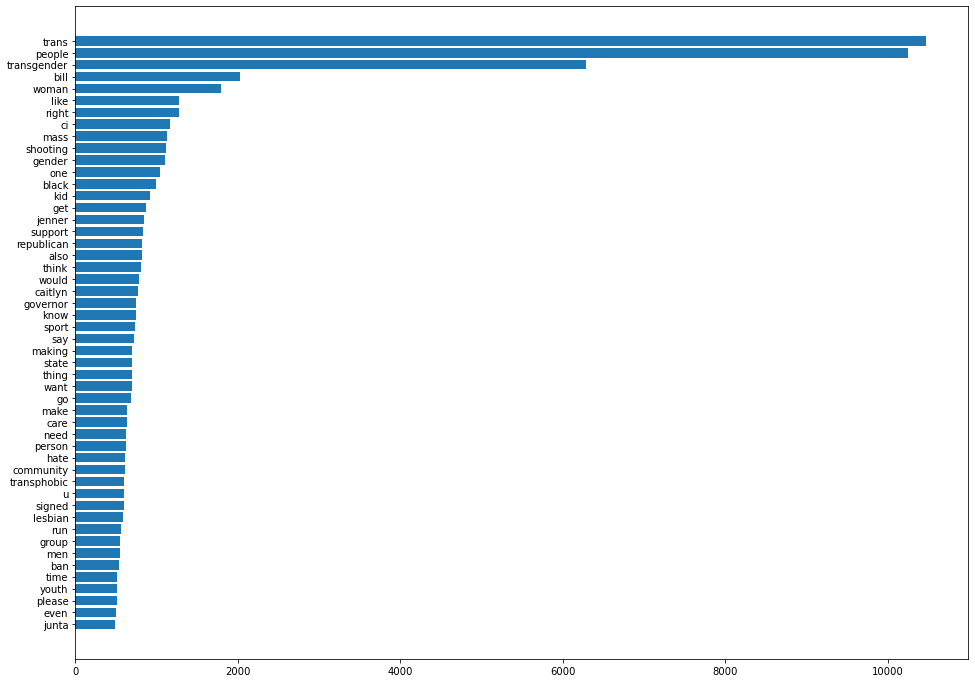

In [3]:
from utils.tokens import build_stopword_set, plot_ngrams
import matplotlib.pyplot as plt

stop = build_stopword_set()

_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=1)
plt.show()

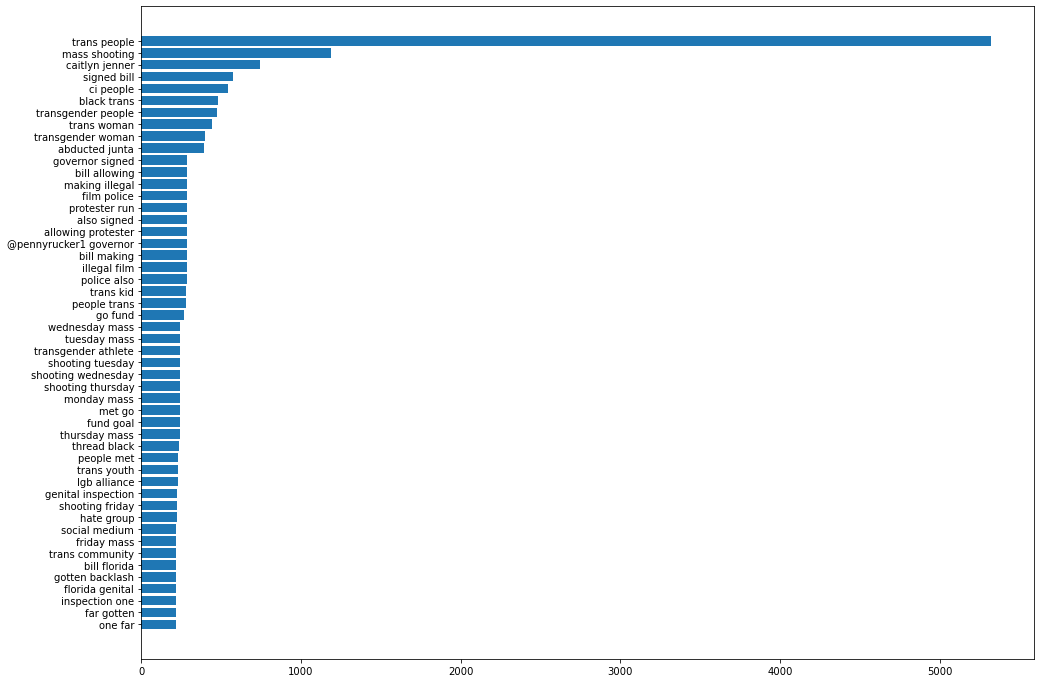

In [4]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=2)
plt.show()

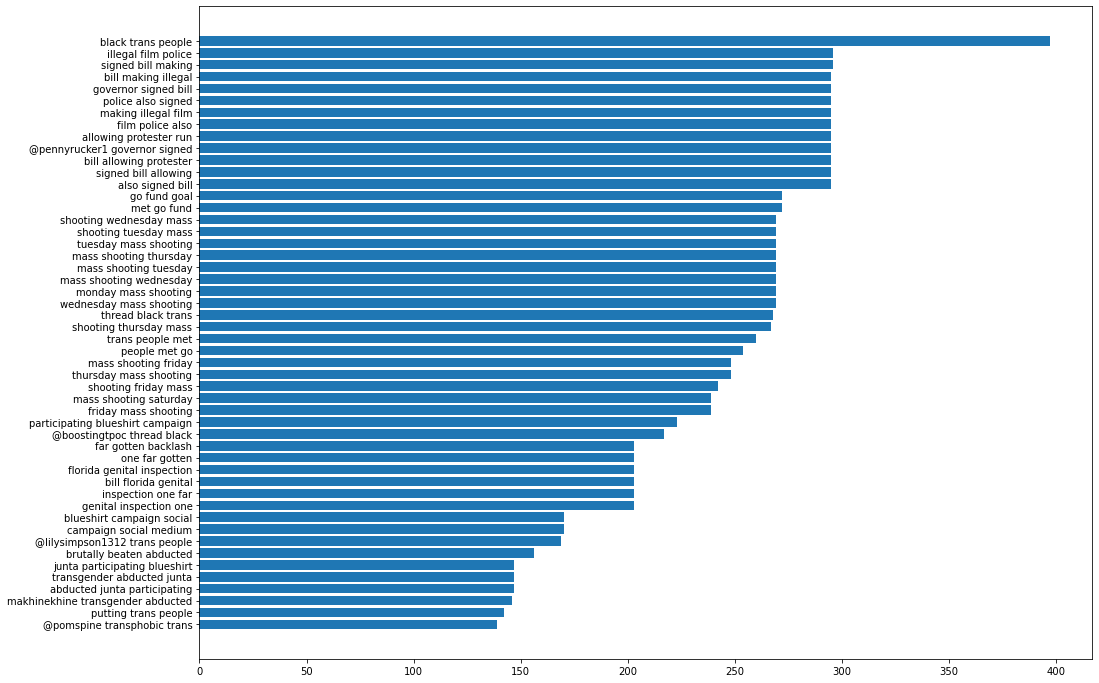

In [5]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=3)
plt.show()

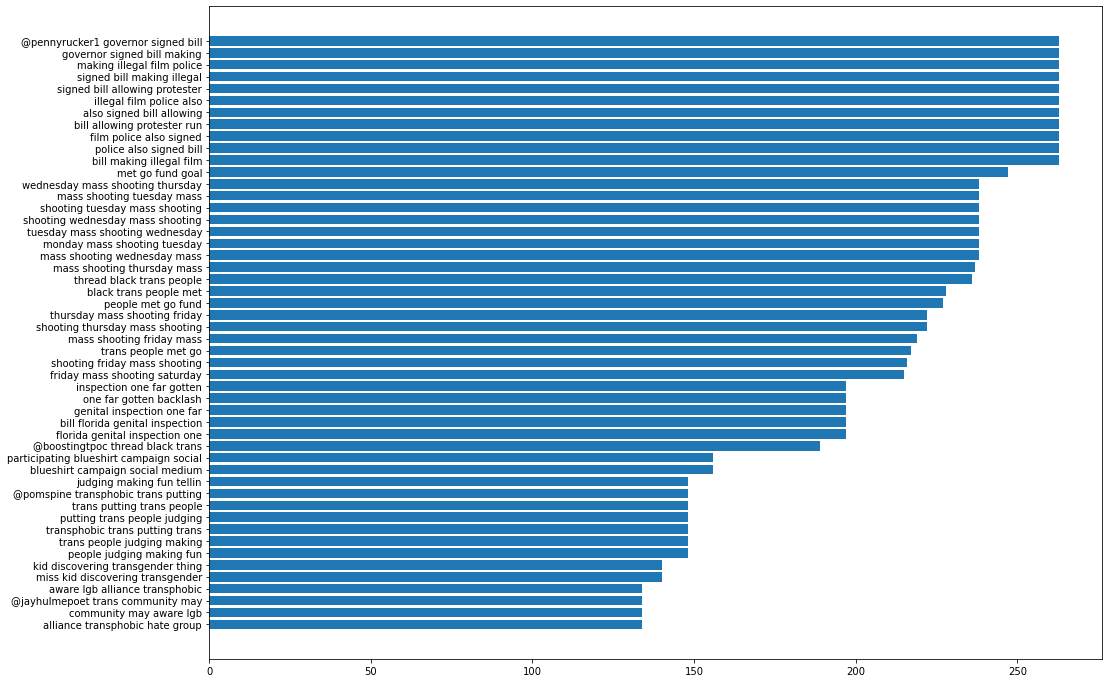

In [6]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=4)
plt.show()

### Interesting notes

1. There is mention of the Myanmar coup, which attacked and abducted Mingalar Taungnyunt, a trans woman protestor (`transgender abducted junta` with 270 hits)
2. A mass shooting on Thursday performed by a trans man (250 ish hits)
3. Caitlyn Jenner running for governor (`caitlyn jenner` with ~750 hits)
4. BLM riots? There seems to be a very-retweeted tweet, which listed bills in Georgia that got signed by the Governor. One of them was an anti-trans bill, the other was a running-over-protestors bill.
5. `@boostingtpoc thread black` trans people who have not met their go fund me goals
6. Various bills where republicans attack trans people in women's sports
    - `florida genital inspection` with 250 hits
    - `texas senate approved sb1646` with 150 hits
    - Non-trans, but also Republican bills get included in these mentions (i.e. illegal to film police, the running over protestors bill)
7. Something about judging trans people (170 hits)
8. Mentions of kids "discovering this transgender thing" (150 hits)

Let's go with **15** LDA topics.

## LDA Time

### Build dictionary and train TF-IDF

In [7]:
import utils.tokens as ut
import logging
import os
import gensim

TFIDF_MODEL_PATH = '../models/tfidf.model'
# Enable logging
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s', level=logging.INFO)

ranged_df = tweet_df
documents = list(ut.tokenize_tweets(ranged_df['tweet'], stop))
dictionary = gensim.corpora.Dictionary(documents)

bow_corpus = [dictionary.doc2bow(doc) for doc in documents]

if os.path.exists(TFIDF_MODEL_PATH):
    tfidf = gensim.models.TfidfModel.load(TFIDF_MODEL_PATH)
else:
    tfidf = gensim.models.TfidfModel(bow_corpus)
    tfidf.save(TFIDF_MODEL_PATH)
corpus_tfidf = tfidf[bow_corpus]

2021-05-04 15:38:23,715 INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-05-04 15:38:23,854 INFO : adding document #10000 to Dictionary(10659 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-04 15:38:24,011 INFO : adding document #20000 to Dictionary(17408 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-04 15:38:24,171 INFO : adding document #30000 to Dictionary(21464 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-04 15:38:24,329 INFO : adding document #40000 to Dictionary(25684 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-04 15:38:24,474 INFO : adding document #50000 to Dictionary(29552 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-04 15:38:24,636 INFO : adding document #60000 to Dictionary(33344 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-0

### Train the LDA model

This takes a while because we have 300k tweets. Let's do it on a smaller sample of them.

In [8]:
import random

TOPICS = 15
LDA_TFIDF_MODEL_PATH = '../models/lda_tfidf.model'

lda_sample = random.choices(corpus_tfidf, k=50_000)

if os.path.exists(LDA_TFIDF_MODEL_PATH):
    lda_model_tfidf = gensim.models.LdaMulticore.load(LDA_TFIDF_MODEL_PATH)
else:
    lda_model_tfidf = gensim.models.LdaMulticore(
        lda_sample,
        num_topics=TOPICS,
        id2word=dictionary,
        passes=10,
        workers=8
    )
    lda_model_tfidf.save(TFIDF_MODEL_PATH)

lda_model_tfidf

2021-05-04 15:38:35,478 INFO : loading LdaMulticore object from ../models/lda_tfidf.model
2021-05-04 15:38:35,480 INFO : loading expElogbeta from ../models/lda_tfidf.model.expElogbeta.npy with mmap=None
2021-05-04 15:38:35,482 INFO : setting ignored attribute dispatcher to None
2021-05-04 15:38:35,483 INFO : setting ignored attribute state to None
2021-05-04 15:38:35,483 INFO : setting ignored attribute id2word to None
2021-05-04 15:38:35,483 INFO : loaded ../models/lda_tfidf.model
2021-05-04 15:38:35,484 INFO : loading LdaState object from ../models/lda_tfidf.model.state
2021-05-04 15:38:35,507 INFO : loaded ../models/lda_tfidf.model.state


### Topics and words

In [9]:
for idx, topic in lda_model_tfidf.print_topics(-1, num_words=10):
    print('{}\t{}'.format(idx, topic))

2021-05-04 15:38:35,580 INFO : topic #0 (0.067): 0.005*"would" + 0.005*"veto" + 0.005*"allowed" + 0.004*"rule" + 0.004*"sport" + 0.004*"transgender" + 0.004*"bill" + 0.004*"people" + 0.003*"homeless" + 0.003*"kansa"
2021-05-04 15:38:35,581 INFO : topic #1 (0.067): 0.007*"transgender" + 0.006*"bill" + 0.005*"lesbian" + 0.005*"state" + 0.005*"trans" + 0.005*"youth" + 0.005*"people" + 0.004*"kid" + 0.004*"right" + 0.004*"woman"
2021-05-04 15:38:35,583 INFO : topic #2 (0.067): 0.009*"care" + 0.005*"view" + 0.005*"real" + 0.005*"support" + 0.005*"asinine" + 0.005*"@cmclymer" + 0.005*"way" + 0.005*"wil" + 0.005*"candidacy" + 0.005*"people"
2021-05-04 15:38:35,584 INFO : topic #3 (0.067): 0.025*"mass" + 0.024*"shooting" + 0.012*"junta" + 0.011*"abducted" + 0.009*"#whatshappeninginmyanmar" + 0.009*"campaign" + 0.009*"brutally" + 0.008*"khine" + 0.008*"blueshirt" + 0.008*"participating"
2021-05-04 15:38:35,585 INFO : topic #4 (0.067): 0.023*"signed" + 0.022*"bill" + 0.013*"inspection" + 0.013*"

0	0.005*"would" + 0.005*"veto" + 0.005*"allowed" + 0.004*"rule" + 0.004*"sport" + 0.004*"transgender" + 0.004*"bill" + 0.004*"people" + 0.003*"homeless" + 0.003*"kansa"
1	0.007*"transgender" + 0.006*"bill" + 0.005*"lesbian" + 0.005*"state" + 0.005*"trans" + 0.005*"youth" + 0.005*"people" + 0.004*"kid" + 0.004*"right" + 0.004*"woman"
2	0.009*"care" + 0.005*"view" + 0.005*"real" + 0.005*"support" + 0.005*"asinine" + 0.005*"@cmclymer" + 0.005*"way" + 0.005*"wil" + 0.005*"candidacy" + 0.005*"people"
3	0.025*"mass" + 0.024*"shooting" + 0.012*"junta" + 0.011*"abducted" + 0.009*"#whatshappeninginmyanmar" + 0.009*"campaign" + 0.009*"brutally" + 0.008*"khine" + 0.008*"blueshirt" + 0.008*"participating"
4	0.023*"signed" + 0.022*"bill" + 0.013*"inspection" + 0.013*"backlash" + 0.013*"genital" + 0.013*"gotten" + 0.013*"illegal" + 0.012*"far" + 0.012*"florida" + 0.012*"film"
5	0.006*"state" + 0.004*"ur" + 0.004*"read" + 0.004*"ca" + 0.004*"@lllster" + 0.004*"oh" + 0.004*"bill" + 0.004*"reviewing" +

### Topic Identification

#### Terms related to the state anti-trans bills

In [10]:
def sum_of_scores(tweets):
    bows = [bow_corpus[i] for i in tweets]
    topic_scores = [0 for _ in range(TOPICS)]

    for tweet_topics in lda_model_tfidf[bows]:
        for idx, score in tweet_topics:
            topic_scores[idx] += score
    return topic_scores


def sort_and_print_topics(topic_scores):
    topics = list(enumerate(topic_scores))
    topics.sort(key=lambda pair: pair[1], reverse=True)
    return topics


def tweets_containing_term(term):
    return tweet_df[tweet_df['tweet'].str.lower().str.find(term) > 0]['i']


sort_and_print_topics(sum_of_scores(tweets_containing_term('senat')))  # to include senate, senator

2021-05-04 15:38:36,289 INFO : NumExpr defaulting to 8 threads.


[(11, 1784.8760569673032),
 (10, 233.75214396044612),
 (8, 204.43571098148823),
 (12, 198.57607824821025),
 (4, 197.3237458905205),
 (1, 171.46677812933922),
 (5, 139.7865847228095),
 (6, 136.2937182355672),
 (0, 97.62977792415768),
 (2, 93.74902137741446),
 (13, 80.70534435845912),
 (3, 75.6357144806534),
 (7, 68.27510469127446),
 (14, 56.8446787185967),
 (9, 48.294446538202465)]

In [11]:
sort_and_print_topics(sum_of_scores(tweets_containing_term('sport')))

[(8, 1434.860084336251),
 (10, 1427.9136319439858),
 (1, 1380.4940137071535),
 (12, 985.8791079316288),
 (2, 618.4279757775366),
 (5, 572.7842737138271),
 (6, 570.851847300306),
 (0, 548.1067692348734),
 (13, 493.5929723633453),
 (7, 477.5522041050717),
 (3, 473.0115795172751),
 (11, 450.2759001022205),
 (4, 439.0171191766858),
 (9, 370.223945829086),
 (14, 328.3323809467256)]

#### Terms related to Myanmar

In [12]:
sort_and_print_topics(sum_of_scores(tweets_containing_term('myanmar')))

[(11, 674.379202012904),
 (10, 601.3795125037432),
 (8, 504.5760301146656),
 (1, 462.46065338142216),
 (12, 297.60858964174986),
 (5, 288.152687786147),
 (0, 224.01319019310176),
 (2, 216.23991517722607),
 (7, 209.43813421204686),
 (6, 171.9469316052273),
 (9, 158.0652456851676),
 (13, 154.95800620689988),
 (4, 81.01991380844265),
 (3, 74.06204798351973),
 (14, 73.16029097139835)]

In [13]:
sort_and_print_topics(sum_of_scores(tweets_containing_term('junta')))

[(10, 945.2225328506902),
 (11, 829.1613543573767),
 (8, 773.2641300754622),
 (1, 674.1251569734886),
 (12, 460.13605873659253),
 (5, 399.94721462391317),
 (0, 379.63167218957096),
 (7, 340.35639377031475),
 (2, 325.1759490771219),
 (6, 248.91297852993011),
 (13, 224.35827802680433),
 (9, 208.06498780939728),
 (4, 123.82911891210824),
 (14, 121.87508499901742),
 (3, 114.35378973651677)]

#### Caitlyn Jenner

In [14]:
sort_and_print_topics(sum_of_scores(tweets_containing_term('caitlyn')))

[(2, 2391.572671772912),
 (10, 1409.882235404104),
 (11, 1405.3024439923465),
 (5, 1394.7874112930149),
 (8, 1297.9321799678728),
 (1, 1179.2312112776563),
 (12, 1038.9858949035406),
 (7, 1029.3531975373626),
 (14, 601.7240588366985),
 (13, 504.7251046895981),
 (0, 420.9400554653257),
 (6, 371.7132935523987),
 (9, 263.0891321701929),
 (4, 251.97382815461606),
 (3, 237.48073362838477)]

In [15]:
sort_and_print_topics(sum_of_scores(tweets_containing_term('jenner')))

[(2, 2479.9729477753863),
 (10, 1703.860478932038),
 (8, 1655.494418689981),
 (5, 1552.5373379066586),
 (11, 1519.1773801017553),
 (1, 1486.318579561077),
 (12, 1389.6105297068134),
 (7, 1218.3040955793113),
 (14, 1046.6354485573247),
 (13, 606.5437133992091),
 (0, 501.77611337509006),
 (6, 429.5186317395419),
 (4, 367.9534580036998),
 (9, 366.64779968746006),
 (3, 312.9118011565879)]

In [16]:
sort_and_print_topics(sum_of_scores(tweets_containing_term('governor')))

[(10, 1427.8643171600997),
 (8, 1367.033013078384),
 (1, 1101.823090611957),
 (14, 998.7675532037392),
 (12, 915.3850093409419),
 (0, 704.4247331088409),
 (2, 698.2904695188627),
 (13, 653.6933401487768),
 (5, 648.459529960528),
 (6, 508.72724683210254),
 (11, 412.49793329369277),
 (9, 348.5406360691413),
 (7, 340.85468781366944),
 (4, 333.37090343795717),
 (3, 329.4621387310326)]

## Cool visualization time!

We'll make a heatmap of what topics are most common at what times. First, we'll reindex the tweets by date.

In [17]:
tweet_time_df = tweet_df.set_index('date')
tweet_time_df.sort_index(inplace=True)
tweet_time_df

,tweet,author,id,i
date,,,,
2021-04-19 21:31:08,"RT @Perletear: @sallyrugg Black women, inferti...",CheNirvana,1384258285826547720,150092
2021-04-19 21:31:26,local transgender makes 'love' on personal grass,localwebwebs,1384258360199979010,150091
2021-04-19 21:32:14,John Bel Edwards won't support bills that ban ...,DarthDandious,1384258562675806216,150090
2021-04-19 21:32:19,Activists sue to keep number of transgender in...,debbies3360,1384258583462772742,150089
2021-04-19 21:32:25,@Ditzy771 @CeeBee64495886 Then it would be mor...,Marina19226553,1384258608544686087,150088
...,...,...,...,...
2021-04-28 03:04:58,RT @zoewhittall: What @TheCurrentCBC is ignori...,IvaCheung,1387241400371089408,4
2021-04-28 03:05:01,"RT @cmclymer: ""Understand the fuller context h...",jay_james84,1387241412329095179,3
2021-04-28 03:05:01,"17 vs now\n\nHonestly, why does anyone but tra...",Ranting_Trans,1387241412576505857,2


Next, we'll group by date periods, aggregating everything into a sum of topic scores.

In [25]:
def agg_topics(group):
    return sum_of_scores(group)


chunked_scores = tweet_time_df['i'].resample('6H').agg(agg_topics)
chunked_scores

date
2021-04-19 18:00:00    [68.41963679343462, 177.79010694194585, 84.971...
2021-04-20 00:00:00    [178.1325268149376, 322.3612329913303, 156.901...
2021-04-20 06:00:00    [301.82348440308124, 423.0381382005289, 265.86...
2021-04-20 12:00:00    [723.5015504946932, 1402.1790558816865, 785.95...
2021-04-20 18:00:00    [463.4838254051283, 1479.378717915155, 657.340...
2021-04-21 00:00:00    [162.23036721348763, 651.9916219227016, 333.14...
2021-04-21 06:00:00    [254.5958747304976, 489.6843418851495, 342.253...
2021-04-21 12:00:00    [473.3999423282221, 900.8927532220259, 522.515...
2021-04-21 18:00:00    [464.1733365384862, 878.3062609704211, 493.898...
2021-04-22 00:00:00    [273.5123744653538, 578.8984356634319, 320.354...
2021-04-22 06:00:00    [205.52646221313626, 447.6919735679403, 252.75...
2021-04-22 12:00:00    [438.01357817463577, 1012.0415252968669, 471.4...
2021-04-22 18:00:00    [552.5066480124369, 1193.3862724779174, 485.09...
2021-04-23 00:00:00    [875.2620604559779, 815

Finally, here is the plot.

2021-05-04 15:45:19,775 INFO : topic #0 (0.067): 0.005*"would" + 0.005*"veto" + 0.005*"allowed" + 0.004*"rule" + 0.004*"sport" + 0.004*"transgender"
2021-05-04 15:45:19,782 INFO : topic #1 (0.067): 0.007*"transgender" + 0.006*"bill" + 0.005*"lesbian" + 0.005*"state" + 0.005*"trans" + 0.005*"youth"
2021-05-04 15:45:19,786 INFO : topic #2 (0.067): 0.009*"care" + 0.005*"view" + 0.005*"real" + 0.005*"support" + 0.005*"asinine" + 0.005*"@cmclymer"
2021-05-04 15:45:19,789 INFO : topic #3 (0.067): 0.025*"mass" + 0.024*"shooting" + 0.012*"junta" + 0.011*"abducted" + 0.009*"#whatshappeninginmyanmar" + 0.009*"campaign"
2021-05-04 15:45:19,792 INFO : topic #4 (0.067): 0.023*"signed" + 0.022*"bill" + 0.013*"inspection" + 0.013*"backlash" + 0.013*"genital" + 0.013*"gotten"
2021-05-04 15:45:19,795 INFO : topic #5 (0.067): 0.006*"state" + 0.004*"ur" + 0.004*"read" + 0.004*"ca" + 0.004*"@lllster" + 0.004*"oh"
2021-05-04 15:45:19,797 INFO : topic #6 (0.067): 0.021*"black" + 0.021*"thread" + 0.021*"met"

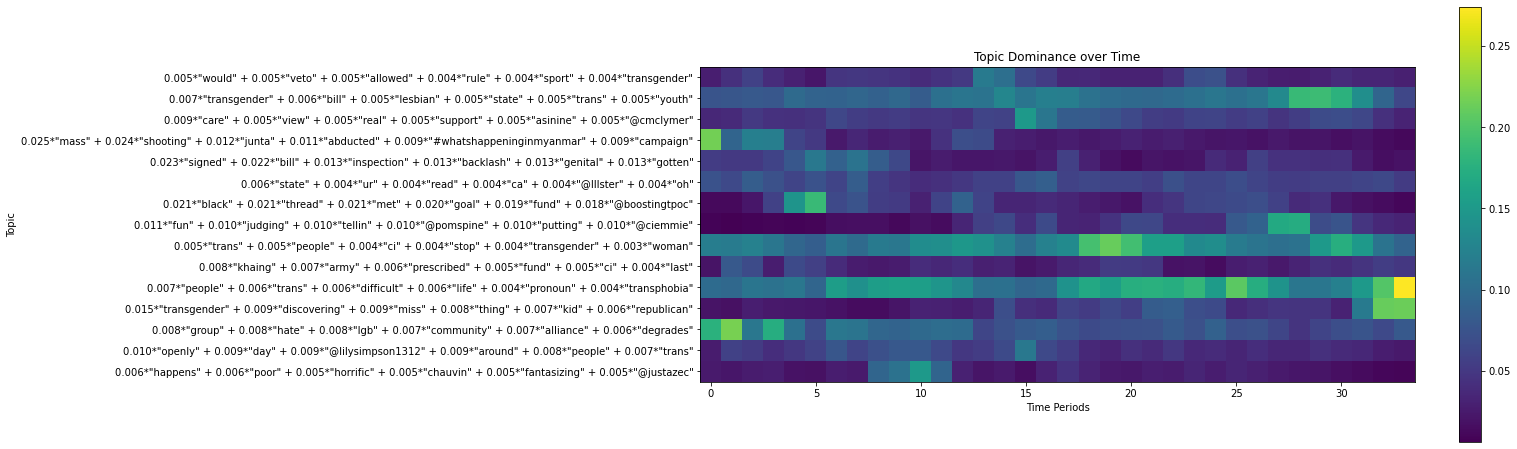

In [28]:
import numpy as np

topics_over_time = np.array(list(chunked_scores)).T
topics_over_time /= topics_over_time.sum(axis=0, keepdims=True)  # normalize by time

yticks = [words for _, words in lda_model_tfidf.print_topics(-1, num_words=6)]

fig, ax = plt.subplots(figsize=(16, 8))

plt.title('Topic Dominance over Time')
plt.xlabel('Time Periods')
plt.ylabel('Topic')

plt.imshow(topics_over_time)
plt.yticks(list(range(TOPICS)), yticks)
plt.colorbar()

plt.show()

## Classifying, somehow?

Let's run [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html) on these tweets. Can we separate tweets or users into pro- and anti- trans?

In [20]:
from nltk import TweetTokenizer

# Get rid of handles
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)


def tokenize_preserve_grammar(tweet):
    return tokenizer.tokenize(tweet)


tweet_docs = [tokenize_preserve_grammar(tweet) for tweet in tweet_df['tweet']]

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

DOC2VEC_PATH = '../models/doc2vec.model'
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tweet_docs)]

if os.path.exists(DOC2VEC_PATH):
    model = Doc2Vec.load(DOC2VEC_PATH)
else:
    model = Doc2Vec(
        documents,
        vector_size=50,
        window=2,
        min_count=1,
        workers=8,
        epochs=50,
        compute_loss=True
    )
    model.save(DOC2VEC_PATH)

2021-05-04 15:41:03,714 INFO : loading Doc2Vec object from ../models/doc2vec.model
2021-05-04 15:41:04,805 INFO : loading vocabulary recursively from ../models/doc2vec.model.vocabulary.* with mmap=None
2021-05-04 15:41:04,806 INFO : loading trainables recursively from ../models/doc2vec.model.trainables.* with mmap=None
2021-05-04 15:41:04,806 INFO : loading wv recursively from ../models/doc2vec.model.wv.* with mmap=None
2021-05-04 15:41:04,807 INFO : loading docvecs recursively from ../models/doc2vec.model.docvecs.* with mmap=None
2021-05-04 15:41:04,807 INFO : loading vectors_docs from ../models/doc2vec.model.docvecs.vectors_docs.npy with mmap=None
2021-05-04 15:41:05,095 INFO : loading vectors_docs_norm from ../models/doc2vec.model.docvecs.vectors_docs_norm.npy with mmap=None
2021-05-04 15:41:05,317 INFO : loaded ../models/doc2vec.model


In [22]:
sample_tweet = tweet_df.iloc[78889]
tokenized_sample = tweet_docs[sample_tweet['i']]
sample_vector = model.infer_vector(tokenized_sample)
print('Tweet: ', sample_tweet['tweet'].replace('\n', ' | '))

for index, similarity in model.docvecs.most_similar([sample_vector]):
    other_tweet = tweet_df.iloc[index]['tweet'].replace('\n', ' |   ')
    print(f'{similarity * 100:.1f}% {other_tweet}')

Tweet:  @ReallyAmerican1 @chipfranklin are you saying trans people cant run for office? thats transphobic
85.8% @ReallyAmerican1 @chipfranklin are you saying trans people cant run for office? thats transphobic
61.9% When did we go from saying transsexual to transgender?
58.2% RT @DoctorPissPants: I would love it if we as trans people could see a bad take and go "oh well" and not even mention it
58.2% @GregorMcConor3 @sewerkamii @LilNasX Straight people have constructed all of society based on their identities and sexuality. wtf are you talking about? Trans people can't even go to the bathroom because straight people don't get it
56.9% RT @EmergeAmerica: Yes, you should run for office more! @EmergeVirginia alum @pwcdanica, you dropped this: 👑 |   https://t.co/qjzAtjfRyB
56.9% RT @DoctorPissPants: I would love it if we as trans people could see a bad take and go "oh well" and not even mention it
56.7% RT @Tucker_bag: When did we go from saying transsexual to transgender?
56.7% RT @Tucker

## Why do people support or oppose trans people?

[Multi sentiment analysis](https://www.cs.cornell.edu/home/cardie/papers/masa-sentire-2011.pdf)